# Difference-in-Differences Analysis for Cooling Interventions

This notebook implements DiD analysis to evaluate cooling interventions effectiveness.

## Data Preparation Steps:
1. Load and prepare master dataframe
2. Create treatment and control groups
3. Define pre and post intervention periods
4. Calculate necessary variables for DiD analysis

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from datetime import datetime, timedelta

# Load the master dataframe and logger flags
master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
logger_flags_df = pd.read_csv('logger_flags.csv')

# Set DateTime as index
master_df = master_df.set_index('DateTime')

# Create dictionary for logger metadata
logger_metadata = logger_flags_df.set_index('Loggers').to_dict('index')

# Define intervention dates
rainbow_intervention_date = pd.to_datetime('2024-07-16')
sports_intervention_date = pd.to_datetime('2024-07-20')

# Display basic information
print('Master dataframe shape:', master_df.shape)
print('\nLogger flags shape:', logger_flags_df.shape)
print('\nLogger flags columns:', logger_flags_df.columns.tolist())

Master dataframe shape: (90832, 46)

Logger flags shape: (42, 9)

Logger flags columns: ['Loggers', 'Shaded', 'Unshaded', 'Settlement', 'Intervention', 'Logger_Type', 'Baseline_Start', 'Intervention_Start', 'Post_Intervention_End']


In [3]:
# Create treatment indicators
treatment_groups = {
    'RBF': logger_flags_df[logger_flags_df['Intervention'] == 'RBF']['Loggers'].tolist(),
    'MEB': logger_flags_df[logger_flags_df['Intervention'] == 'MEB']['Loggers'].tolist(),
    'Control': logger_flags_df[logger_flags_df['Intervention'] == 'CONTROL']['Loggers'].tolist()
}

# Create settlement indicators
settlements = {
    'Rainbow Field': logger_flags_df[logger_flags_df['Settlement'] == 'Rainbow Field']['Loggers'].tolist(),
    'Sports Complex': logger_flags_df[logger_flags_df['Settlement'] == 'Sports Complex']['Loggers'].tolist()
}

# Create shading indicators
shading = {
    'Shaded': logger_flags_df[logger_flags_df['Shaded'] == True]['Loggers'].tolist(),
    'Unshaded': logger_flags_df[logger_flags_df['Shaded'] == False]['Loggers'].tolist()
}

print("Number of loggers in each treatment group:")
for group, loggers in treatment_groups.items():
    print(f"{group}: {len(loggers)}")

print("\nNumber of loggers in each settlement:")
for settlement, loggers in settlements.items():
    print(f"{settlement}: {len(loggers)}")

print("\nNumber of loggers by shading:")
for shade, loggers in shading.items():
    print(f"{shade}: {len(loggers)}")

Number of loggers in each treatment group:
RBF: 15
MEB: 11
Control: 16

Number of loggers in each settlement:
Rainbow Field: 14
Sports Complex: 28

Number of loggers by shading:
Shaded: 19
Unshaded: 23


In [4]:
# Function to create DiD dataset for a specific logger
def prepare_logger_data(logger_id):
    # Get logger metadata
    metadata = logger_metadata[logger_id]
    
    # Get temperature data and align with environmental data
    temp_data = master_df[logger_id]
    env_temp = master_df['Env_Temperature']
    
    # Create DataFrame with aligned data
    data = pd.DataFrame({
        'Temperature': temp_data,
        'Env_Temperature': env_temp,
        'Temperature_Difference': temp_data - env_temp,
        'Logger': logger_id,
        'Settlement': metadata['Settlement'],
        'Shaded': metadata['Shaded'],
        'Treatment': metadata['Intervention'] in ['RBF', 'MEB'],
        'RBF': metadata['Intervention'] == 'RBF',
        'MEB': metadata['Intervention'] == 'MEB'
    })
    
    # Add time-based features using the index
    data['Hour'] = data.index.hour
    data['Date'] = data.index.date
    data['Daytime'] = (data['Hour'] >= 6) & (data['Hour'] < 19)
    
    # Add post-intervention indicator
    intervention_date = rainbow_intervention_date if metadata['Settlement'] == 'Rainbow Field' else sports_intervention_date
    data['Post'] = data.index >= intervention_date
    
    return data.dropna()  # Remove any rows with missing data

# Prepare data for all loggers
did_data = []
for logger in master_df.columns:
    if logger != 'Env_Temperature' and logger in logger_metadata:
        logger_data = prepare_logger_data(logger)
        did_data.append(logger_data)

# Combine all logger data
did_df = pd.concat(did_data)

# Create interaction terms
did_df['Post_Treatment'] = did_df['Post'] * did_df['Treatment']
did_df['Post_RBF'] = did_df['Post'] * did_df['RBF']
did_df['Post_MEB'] = did_df['Post'] * did_df['MEB']

# Display information about the prepared dataset
print("DiD dataset shape:", did_df.shape)
print("\nColumns:", did_df.columns.tolist())
print("\nSample of the prepared data:")
print(did_df.head())

# Basic checks
print("\nNumber of observations by treatment and period:")
print(did_df.groupby(['Treatment', 'Post']).size())

print("\nMissing values:")
print(did_df.isnull().sum())

C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_38484\741109265.py:45: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  did_df['Post_Treatment'] = did_df['Post'] * did_df['Treatment']
C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_38484\741109265.py:46: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  did_df['Post_RBF'] = did_df['Post'] * did_df['RBF']
C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_38484\741109265.py:47: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  did_df['Post_MEB'] = did_df['Post'] * did_df['MEB']


DiD dataset shape: (2279880, 16)

Columns: ['Temperature', 'Env_Temperature', 'Temperature_Difference', 'Logger', 'Settlement', 'Shaded', 'Treatment', 'RBF', 'MEB', 'Hour', 'Date', 'Daytime', 'Post', 'Post_Treatment', 'Post_RBF', 'Post_MEB']

Sample of the prepared data:
                     Temperature  Env_Temperature  Temperature_Difference  \
DateTime                                                                    
2024-07-17 01:27:00        31.28        30.820000                0.460000   
2024-07-17 01:28:00        31.30        30.813333                0.486667   
2024-07-17 01:29:00        31.33        30.806667                0.523333   
2024-07-17 01:30:00        31.36        30.800000                0.560000   
2024-07-17 01:31:00        31.39        30.793333                0.596667   

                    Logger      Settlement  Shaded  Treatment    RBF    MEB  \
DateTime                                                                      
2024-07-17 01:27:00   R-01  Sp

## Parallel Trends Analysis and Initial DiD Models

1. Visualize parallel trends for:
   - Overall treatment effect
   - Separate RBF and MEB effects
   - Settlement-specific effects
   - Shading-specific effects

2. Run basic DiD regressions:
   - Pooled treatment effect
   - Separate RBF and MEB effects
   - Heterogeneous effects by settlement and shading

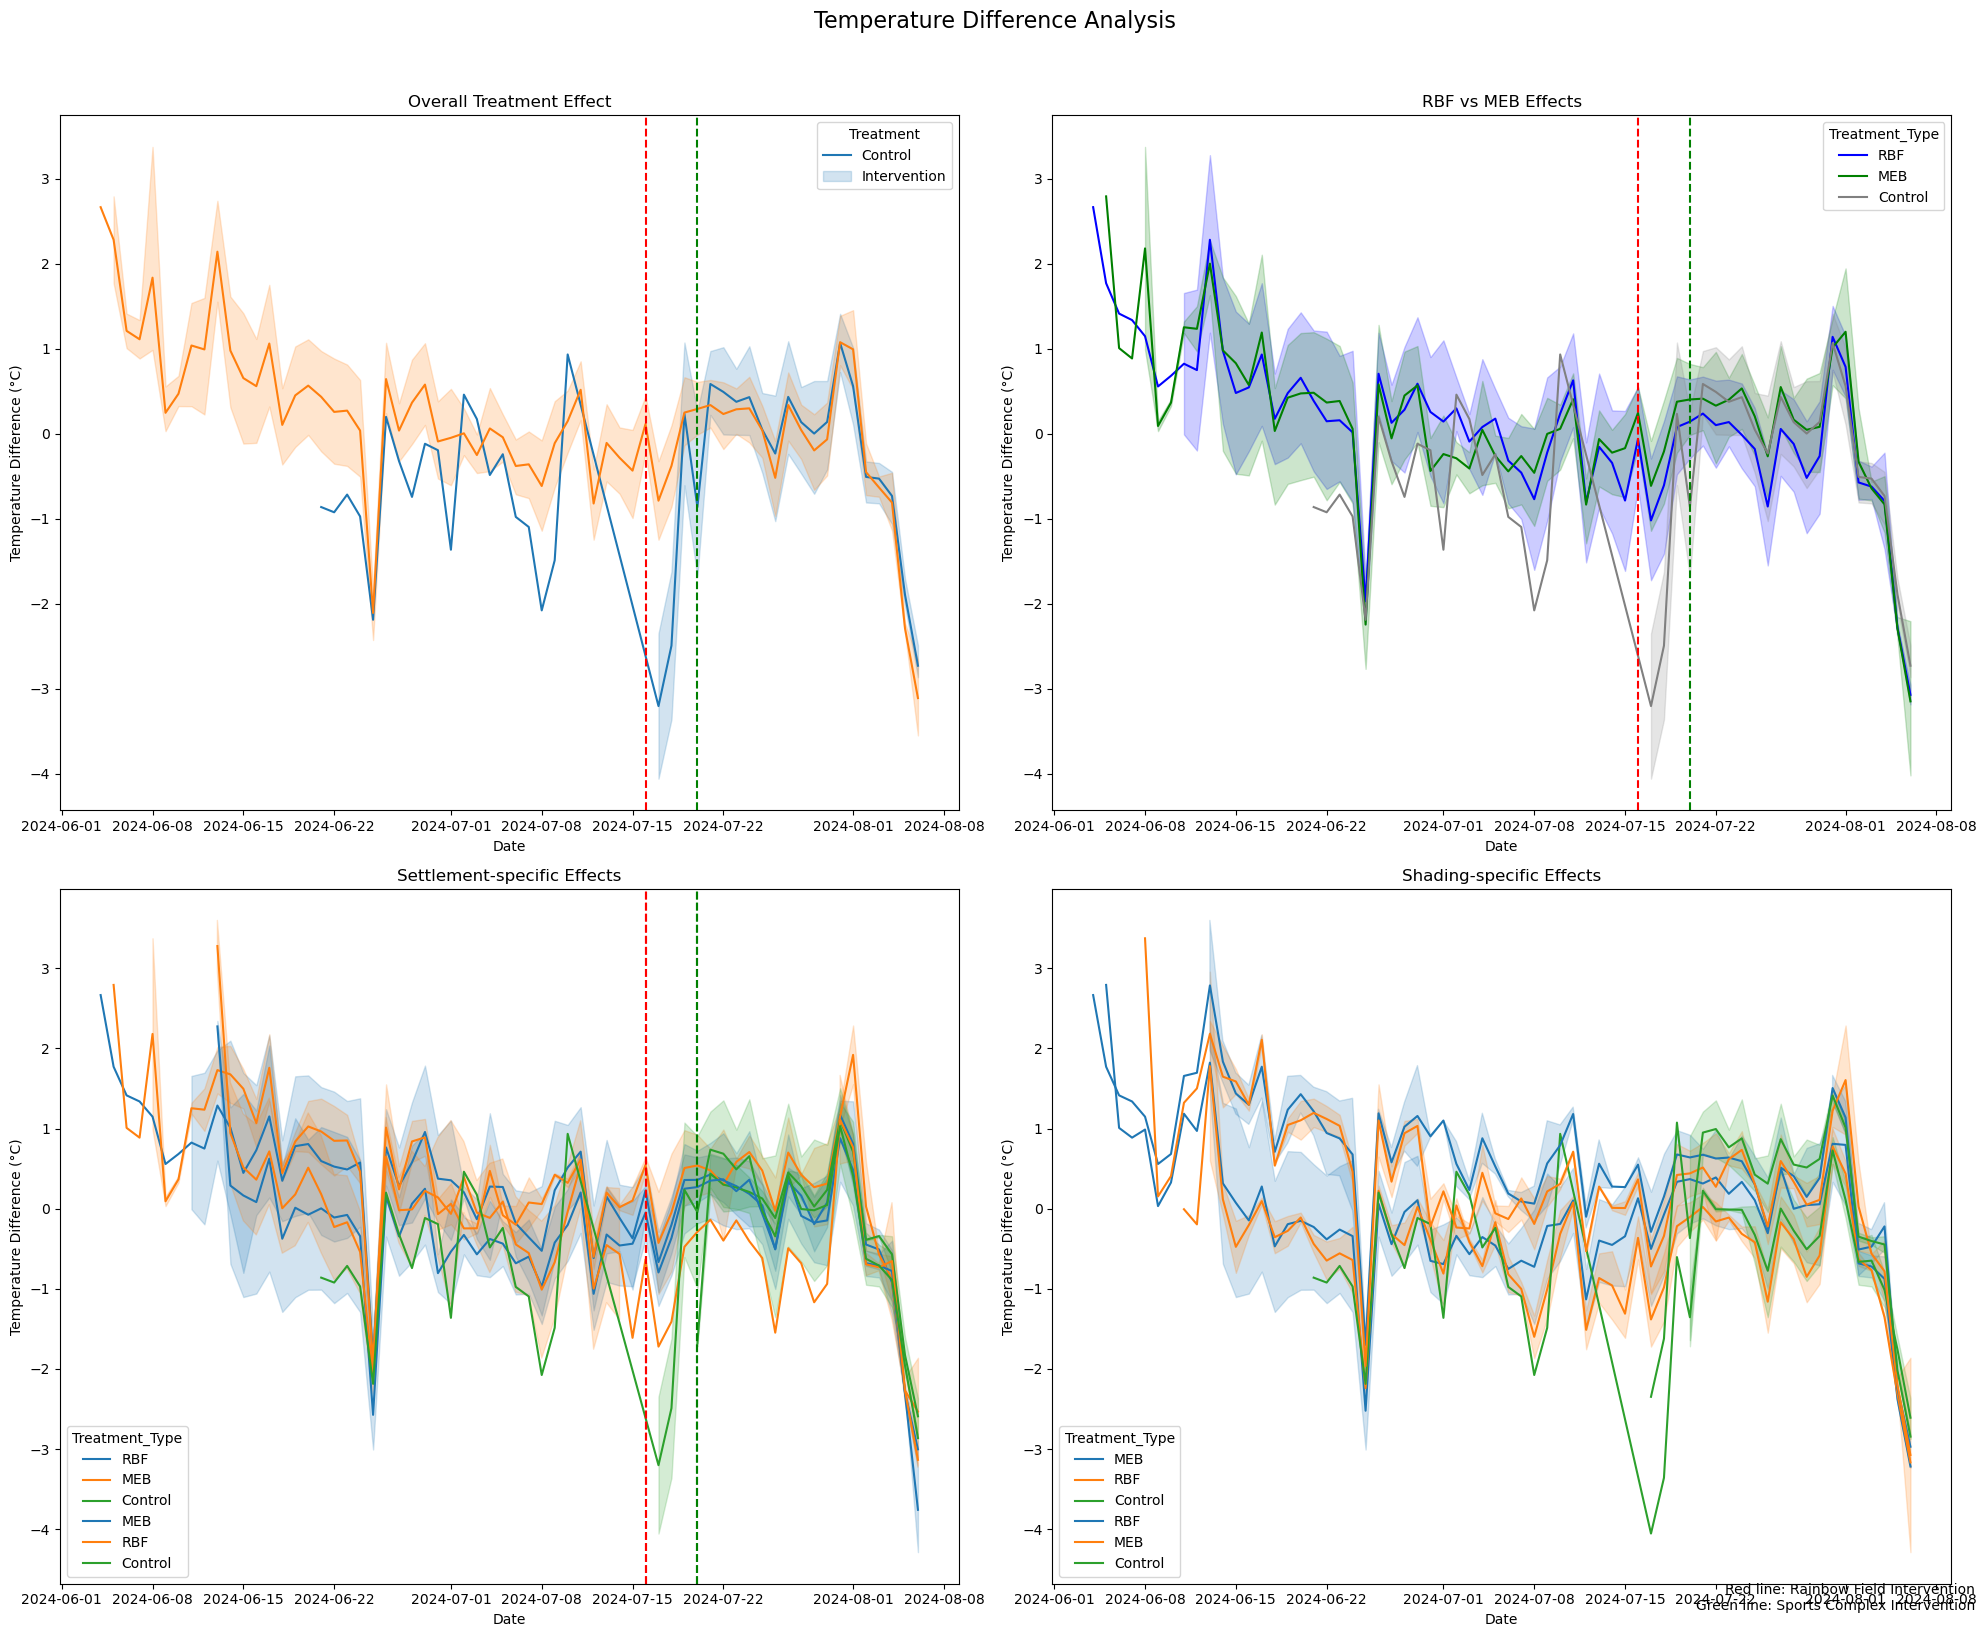


Mean Temperature Differences by Period and Treatment:
                     mean       std    count
Post  Treatment                             
False False     -0.944661  3.334930    56834
      True      -0.137657  3.047905  1182317
True  False      0.033355  2.644852   379779
      True      -0.281413  2.131559   660950

Mean Temperature Differences by Period and Intervention Type:
                  mean       std   count
Pre-Control  -0.944661  3.334930   56834
Pre-MEB      -0.148013  2.934023  512579
Pre-RBF      -0.129731  3.132246  669738
Post-Control  0.033355  2.644852  379779
Post-MEB     -0.142324  2.407696  293520
Post-RBF     -0.392524  1.874684  367430


In [5]:
# Calculate daily averages for different groups
daily_avg = did_df.groupby(['Date', 'Treatment', 'RBF', 'MEB', 'Settlement', 'Shaded'])['Temperature_Difference'].mean().reset_index()

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Overall Treatment Effect
sns.lineplot(data=daily_avg, x='Date', y='Temperature_Difference', 
            hue='Treatment', ax=ax1)
ax1.axvline(x=rainbow_intervention_date, color='r', linestyle='--')
ax1.axvline(x=sports_intervention_date, color='g', linestyle='--')
ax1.set_title('Overall Treatment Effect')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature Difference (°C)')
ax1.legend(title='Treatment', labels=['Control', 'Intervention'])

# 2. Separate RBF and MEB Effects
daily_avg['Treatment_Type'] = 'Control'
daily_avg.loc[daily_avg['RBF'], 'Treatment_Type'] = 'RBF'
daily_avg.loc[daily_avg['MEB'], 'Treatment_Type'] = 'MEB'

sns.lineplot(data=daily_avg, x='Date', y='Temperature_Difference', 
            hue='Treatment_Type', ax=ax2,
            palette={'Control': 'gray', 'RBF': 'blue', 'MEB': 'green'})
ax2.axvline(x=rainbow_intervention_date, color='r', linestyle='--')
ax2.axvline(x=sports_intervention_date, color='g', linestyle='--')
ax2.set_title('RBF vs MEB Effects')
ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature Difference (°C)')

# 3. Settlement-specific Effects
for settlement in ['Rainbow Field', 'Sports Complex']:
    settlement_data = daily_avg[daily_avg['Settlement'] == settlement]
    sns.lineplot(data=settlement_data, x='Date', y='Temperature_Difference', 
                hue='Treatment_Type', ax=ax3)
ax3.axvline(x=rainbow_intervention_date, color='r', linestyle='--')
ax3.axvline(x=sports_intervention_date, color='g', linestyle='--')
ax3.set_title('Settlement-specific Effects')
ax3.set_xlabel('Date')
ax3.set_ylabel('Temperature Difference (°C)')

# 4. Shading-specific Effects
for shaded in [True, False]:
    shading_data = daily_avg[daily_avg['Shaded'] == shaded]
    sns.lineplot(data=shading_data, x='Date', y='Temperature_Difference', 
                hue='Treatment_Type', ax=ax4)
ax3.axvline(x=rainbow_intervention_date, color='r', linestyle='--')
ax3.axvline(x=sports_intervention_date, color='g', linestyle='--')
ax4.set_title('Shading-specific Effects')
ax4.set_xlabel('Date')
ax4.set_ylabel('Temperature Difference (°C)')

# Add a common legend for intervention dates
fig.suptitle('Temperature Difference Analysis', fontsize=16, y=1.02)
fig.text(0.99, 0.02, 'Red line: Rainbow Field Intervention\nGreen line: Sports Complex Intervention', 
         ha='right', fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nMean Temperature Differences by Period and Treatment:")
print(did_df.groupby(['Post', 'Treatment'])['Temperature_Difference'].agg(['mean', 'std', 'count']))

print("\nMean Temperature Differences by Period and Intervention Type:")
summary_stats = did_df.groupby(['Post', 'RBF', 'MEB'])['Temperature_Difference'].agg(['mean', 'std', 'count'])
summary_stats.index = summary_stats.index.map(lambda x: f"{'Post' if x[0] else 'Pre'}-{'RBF' if x[1] else 'MEB' if x[2] else 'Control'}")
print(summary_stats)

# Difference-in-Differences Regression Models for Informal Settlements Cooling Study

Below are the mathematical formulations for each regression model in our analysis:

## 1. Basic DiD Model

$$Y_{it} = \beta_0 + \beta_1 \text{Post}_t + \beta_2 \text{Treatment}_i + \beta_3 (\text{Post}_t \times \text{Treatment}_i) + \varepsilon_{it}$$

Where:
- $Y_{it}$ is the temperature difference for unit $i$ at time $t$
- $\beta_0$ is the constant term (baseline temperature difference)
- $\text{Post}_t$ is a binary indicator equal to 1 for post-intervention period
- $\text{Treatment}_i$ is a binary indicator equal to 1 for treatment units
- $\text{Post}_t \times \text{Treatment}_i$ is the interaction term representing the DiD effect
- $\varepsilon_{it}$ is the error term
- $\beta_3$ is the causal effect of the intervention

## 2. Separate Interventions Model

$$Y_{it} = \beta_0 + \beta_1 \text{Post}_t + \beta_2 \text{RBF}_i + \beta_3 \text{MEB}_i + \beta_4 (\text{Post}_t \times \text{RBF}_i) + \beta_5 (\text{Post}_t \times \text{MEB}_i) + \varepsilon_{it}$$

Where:
- $\text{RBF}_i$ is a binary indicator equal to 1 for units treated with Radiant Barrier Foil
- $\text{MEB}_i$ is a binary indicator equal to 1 for units treated with Mylar Emergency Blankets
- $\beta_4$ is the causal effect of RBF intervention
- $\beta_5$ is the causal effect of MEB intervention

## 3. Controls Model

$$Y_{it} = \beta_0 + \beta_1 \text{Post}_t + \beta_2 \text{Treatment}_i + \beta_3 (\text{Post}_t \times \text{Treatment}_i) + \beta_4 \text{Shaded}_i + \beta_5 \text{Settlement}_i + \beta_6 \text{Daytime}_t + \varepsilon_{it}$$

Where:
- $\text{Shaded}_i$ is a binary indicator equal to 1 for shaded structures
- $\text{Settlement}_i$ is a categorical variable indicating the settlement type
- $\text{Daytime}_t$ is a binary indicator equal to 1 for daytime observations

## 4. Heterogeneous Effects Model

$$\begin{align}
Y_{it} = \beta_0 &+ \beta_1 \text{Post}_t + \beta_2 \text{Treatment}_i + \beta_3 (\text{Post}_t \times \text{Treatment}_i) \\
&+ \beta_4 \text{Shaded}_i + \beta_5 \text{Settlement}_i + \beta_6 \text{Daytime}_t \\
&+ \beta_7 (\text{Post}_t \times \text{Treatment}_i \times \text{Shaded}_i) \\
&+ \beta_8 (\text{Post}_t \times \text{Treatment}_i \times \text{Settlement}_i) \\
&+ \beta_9 (\text{Post}_t \times \text{Treatment}_i \times \text{Daytime}_t) + \varepsilon_{it}
\end{align}$$

Where:
- $\beta_7$ represents the differential effect of the intervention on shaded vs. unshaded structures
- $\beta_8$ represents the differential effect of the intervention between settlements
- $\beta_9$ represents the differential effect of the intervention during daytime vs. nighttime

## Variable Definitions

- **Temperature_Difference** ($Y_{it}$): The difference between indoor and outdoor temperatures (°C)
- **Post** ($\text{Post}_t$): Equal to 1 for observations after the intervention date, 0 otherwise
- **Treatment** ($\text{Treatment}_i$): Equal to 1 for structures receiving any intervention, 0 for control structures
- **RBF** ($\text{RBF}_i$): Equal to 1 for structures receiving Radiant Barrier Foil, 0 otherwise
- **MEB** ($\text{MEB}_i$): Equal to 1 for structures receiving Mylar Emergency Blankets, 0 otherwise
- **Shaded** ($\text{Shaded}_i$): Equal to 1 for structures with existing shade, 0 for unshaded structures
- **Settlement_num** ($\text{Settlement}_i$): Categorical variable identifying the settlement (Rainbow Field or Sports Complex)
- **Daytime** ($\text{Daytime}_t$): Equal to 1 for observations during daylight hours, 0 for nighttime observations

In [6]:
# Prepare data for regression analysis
print("Preparing regression data...")

# First, create a copy of the data for regression
regression_data = did_df.copy()

# Convert boolean columns to numeric
regression_data['Post'] = regression_data['Post'].astype(int)
regression_data['Treatment'] = regression_data['Treatment'].astype(int)
regression_data['Shaded'] = regression_data['Shaded'].astype(int)
regression_data['RBF'] = regression_data['RBF'].astype(int)
regression_data['MEB'] = regression_data['MEB'].astype(int)
regression_data['Daytime'] = regression_data['Daytime'].astype(int)

# Create numeric columns
regression_data['Settlement_num'] = (regression_data['Settlement'] == 'Sports Complex').astype(int)

# Ensure Temperature_Difference is numeric
regression_data['Temperature_Difference'] = pd.to_numeric(regression_data['Temperature_Difference'], errors='coerce')

# Create interaction terms
regression_data['Post_Treatment'] = regression_data['Post'] * regression_data['Treatment']
regression_data['Post_RBF'] = regression_data['Post'] * regression_data['RBF']
regression_data['Post_MEB'] = regression_data['Post'] * regression_data['MEB']
regression_data['Post_Treatment_Shaded'] = regression_data['Post_Treatment'] * regression_data['Shaded']
regression_data['Post_Treatment_Settlement'] = regression_data['Post_Treatment'] * regression_data['Settlement_num']
regression_data['Post_Treatment_Daytime'] = regression_data['Post_Treatment'] * regression_data['Daytime']

# Drop any rows with NaN values
regression_data = regression_data.dropna(subset=['Temperature_Difference'])

# Print data preparation summary
print("\nData preparation summary:")
print(f"Original observations: {len(did_df)}")
print(f"Observations after cleaning: {len(regression_data)}")
print("\nVariable statistics:")
print(regression_data[['Temperature_Difference', 'Post', 'Treatment', 'Post_Treatment']].describe())

# Dictionary to store regression results
models = {}

# 1. Basic DiD Model
print("\nRunning Basic DiD Model...")
X_basic = sm.add_constant(regression_data[['Post', 'Treatment', 'Post_Treatment']])
models['basic'] = sm.OLS(regression_data['Temperature_Difference'], X_basic).fit(
    cov_type='cluster', 
    cov_kwds={'groups': regression_data['Logger']}
)

# 2. Separate RBF and MEB Effects
print("Running Separate RBF/MEB Model...")
X_separate = sm.add_constant(regression_data[['Post', 'RBF', 'MEB', 'Post_RBF', 'Post_MEB']])
models['separate'] = sm.OLS(regression_data['Temperature_Difference'], X_separate).fit(
    cov_type='cluster', 
    cov_kwds={'groups': regression_data['Logger']}
)

# 3. Model with Controls
print("Running Model with Controls...")
X_controls = sm.add_constant(regression_data[[
    'Post', 'Treatment', 'Post_Treatment',
    'Shaded', 'Settlement_num', 'Daytime'
]])
models['controls'] = sm.OLS(regression_data['Temperature_Difference'], X_controls).fit(
    cov_type='cluster', 
    cov_kwds={'groups': regression_data['Logger']}
)

# 4. Full Heterogeneous Effects Model
print("Running Heterogeneous Effects Model...")
X_hetero = sm.add_constant(regression_data[[
    'Post', 'Treatment', 'Post_Treatment',
    'Shaded', 'Settlement_num', 'Daytime',
    'Post_Treatment_Shaded', 'Post_Treatment_Settlement', 'Post_Treatment_Daytime'
]])
models['hetero'] = sm.OLS(regression_data['Temperature_Difference'], X_hetero).fit(
    cov_type='cluster', 
    cov_kwds={'groups': regression_data['Logger']}
)

# Print results function (same as before)
def print_model_results(model, title):
    print("\n" + "="*80)
    print(f"\n{title}")
    print("="*80)
    
    # Print key coefficients with statistical significance
    coef = model.params
    conf = model.conf_int()
    std_err = model.bse
    t_stat = model.tvalues
    p_val = model.pvalues
    
    results_df = pd.DataFrame({
        'Coefficient': coef,
        'Std Error': std_err,
        't-stat': t_stat,
        'P-value': p_val,
        'CI Lower': conf[0],
        'CI Upper': conf[1]
    })
    
    # Add stars for significance
    def add_stars(p_value):
        if p_value < 0.01:
            return '***'
        elif p_value < 0.05:
            return '**'
        elif p_value < 0.1:
            return '*'
        return ''
    
    results_df['Significance'] = results_df['P-value'].apply(add_stars)
    
    print("\nRegression Results:")
    print(results_df.round(4))
    
    # Print model statistics
    print("\nModel Statistics:")
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
    print(f"F-statistic: {model.fvalue:.4f}")
    print(f"Number of observations: {model.nobs}")

# Print results for all models
print_model_results(models['basic'], "Basic DiD Model")
print_model_results(models['separate'], "Separate RBF and MEB Effects Model")
print_model_results(models['controls'], "Model with Controls")
print_model_results(models['hetero'], "Heterogeneous Effects Model")

# Calculate and print treatment effects
print("\n" + "="*80)
print("\nTreatment Effect Estimates:")
print("="*80)

# Basic Treatment Effect
ate = models['basic'].params['Post_Treatment']
ate_se = models['basic'].bse['Post_Treatment']
print(f"\nOverall Average Treatment Effect: {ate:.3f}°C (SE: {ate_se:.3f})")

# Separate RBF and MEB Effects
rbf_effect = models['separate'].params['Post_RBF']
rbf_se = models['separate'].bse['Post_RBF']
meb_effect = models['separate'].params['Post_MEB']
meb_se = models['separate'].bse['Post_MEB']
print(f"RBF Effect: {rbf_effect:.3f}°C (SE: {rbf_se:.3f})")
print(f"MEB Effect: {meb_effect:.3f}°C (SE: {meb_se:.3f})")

# Heterogeneous Effects
base_effect = models['hetero'].params['Post_Treatment']
shaded_interaction = models['hetero'].params['Post_Treatment_Shaded']
settlement_interaction = models['hetero'].params['Post_Treatment_Settlement']
daytime_interaction = models['hetero'].params['Post_Treatment_Daytime']

print("\nHeterogeneous Treatment Effects:")
print(f"Base Effect (Unshaded, Rainbow Field, Night): {base_effect:.3f}°C")
print(f"Additional Effect of Shading: {shaded_interaction:.3f}°C")
print(f"Additional Effect of Sports Complex: {settlement_interaction:.3f}°C")
print(f"Additional Effect during Daytime: {daytime_interaction:.3f}°C")

# Save results to a file
with open('did_regression_results.txt', 'w') as f:
    for model_name, model in models.items():
        f.write(f"\n{model_name.upper()} MODEL RESULTS\n")
        f.write("="*80 + "\n")
        f.write(model.summary().as_text())
        f.write("\n\n")

print("\nDetailed results have been saved to 'did_regression_results.txt'")

Preparing regression data...

Data preparation summary:
Original observations: 2279880
Observations after cleaning: 2279880

Variable statistics:
       Temperature_Difference          Post     Treatment  Post_Treatment
count            2.279880e+06  2.279880e+06  2.279880e+06    2.279880e+06
mean            -1.709633e-01  4.564841e-01  8.084930e-01    2.899056e-01
std              2.757393e+00  4.981029e-01  3.934872e-01    4.537185e-01
min             -1.210000e+01  0.000000e+00  0.000000e+00    0.000000e+00
25%             -1.700000e+00  0.000000e+00  1.000000e+00    0.000000e+00
50%             -2.000000e-01  0.000000e+00  1.000000e+00    0.000000e+00
75%              1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00
max              2.551833e+01  1.000000e+00  1.000000e+00    1.000000e+00

Running Basic DiD Model...
Running Separate RBF/MEB Model...
Running Model with Controls...
Running Heterogeneous Effects Model...


Basic DiD Model

Regression Results:
                C

In [8]:
try:
    # Test if models exists
    models
except NameError:
    print("Models dictionary not found. Running regression models...")
    # Dictionary to store regression results
    models = {}

    # 1. Basic DiD Model
    print("\nRunning Basic DiD Model...")
    X_basic = sm.add_constant(regression_data[['Post', 'Treatment', 'Post_Treatment']])
    models['basic'] = sm.OLS(regression_data['Temperature_Difference'], X_basic).fit(
        cov_type='cluster', 
        cov_kwds={'groups': regression_data['Logger']}
    )

    # 2. Separate RBF and MEB Effects
    print("Running Separate RBF/MEB Model...")
    X_separate = sm.add_constant(regression_data[['Post', 'RBF', 'MEB', 'Post_RBF', 'Post_MEB']])
    models['separate'] = sm.OLS(regression_data['Temperature_Difference'], X_separate).fit(
        cov_type='cluster', 
        cov_kwds={'groups': regression_data['Logger']}
    )

    # 3. Model with Controls
    print("Running Model with Controls...")
    X_controls = sm.add_constant(regression_data[['Post', 'Treatment', 'Post_Treatment',
                                              'Shaded', 'Settlement_num', 'Daytime']])
    models['controls'] = sm.OLS(regression_data['Temperature_Difference'], X_controls).fit(
        cov_type='cluster', 
        cov_kwds={'groups': regression_data['Logger']}
    )

    # 4. Full Heterogeneous Effects Model
    print("Running Heterogeneous Effects Model...")
    X_hetero = sm.add_constant(regression_data[['Post', 'Treatment', 'Post_Treatment',
                                             'Shaded', 'Settlement_num', 'Daytime',
                                             'Post_Treatment_Shaded', 'Post_Treatment_Settlement', 'Post_Treatment_Daytime']])
    models['hetero'] = sm.OLS(regression_data['Temperature_Difference'], X_hetero).fit(
        cov_type='cluster', 
        cov_kwds={'groups': regression_data['Logger']}
    )

## Create Plots

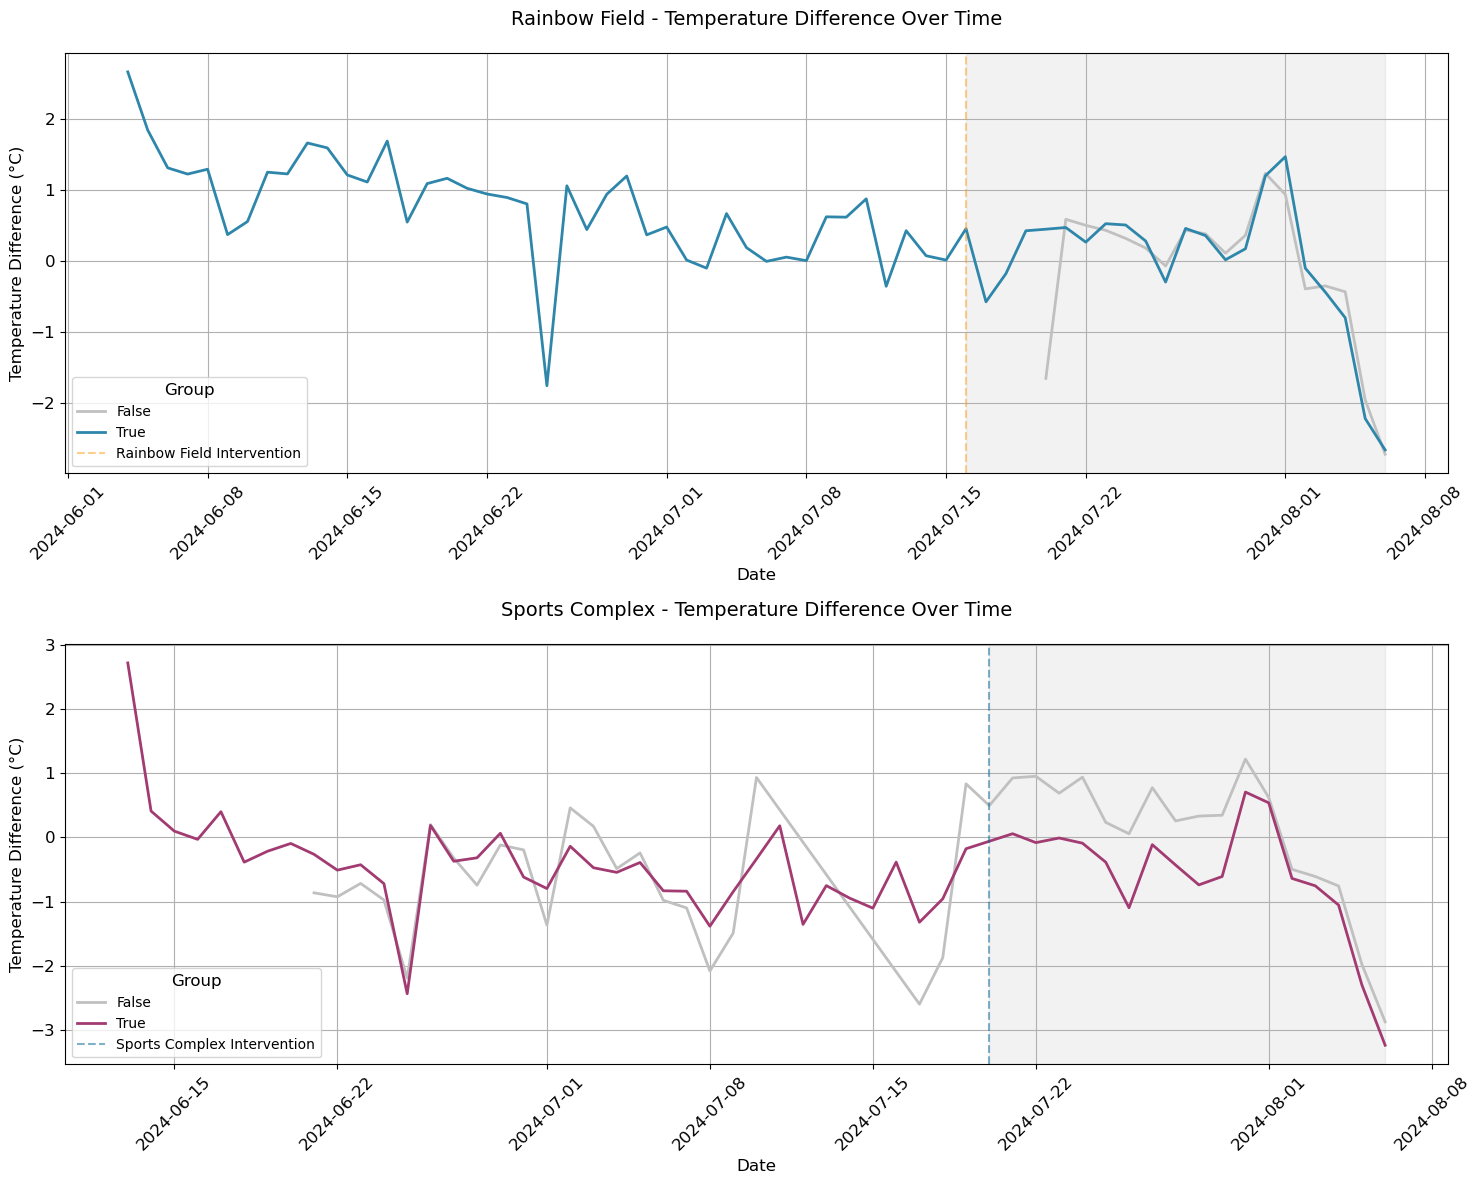

C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_38484\3266307891.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_38484\3266307891.py:88: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


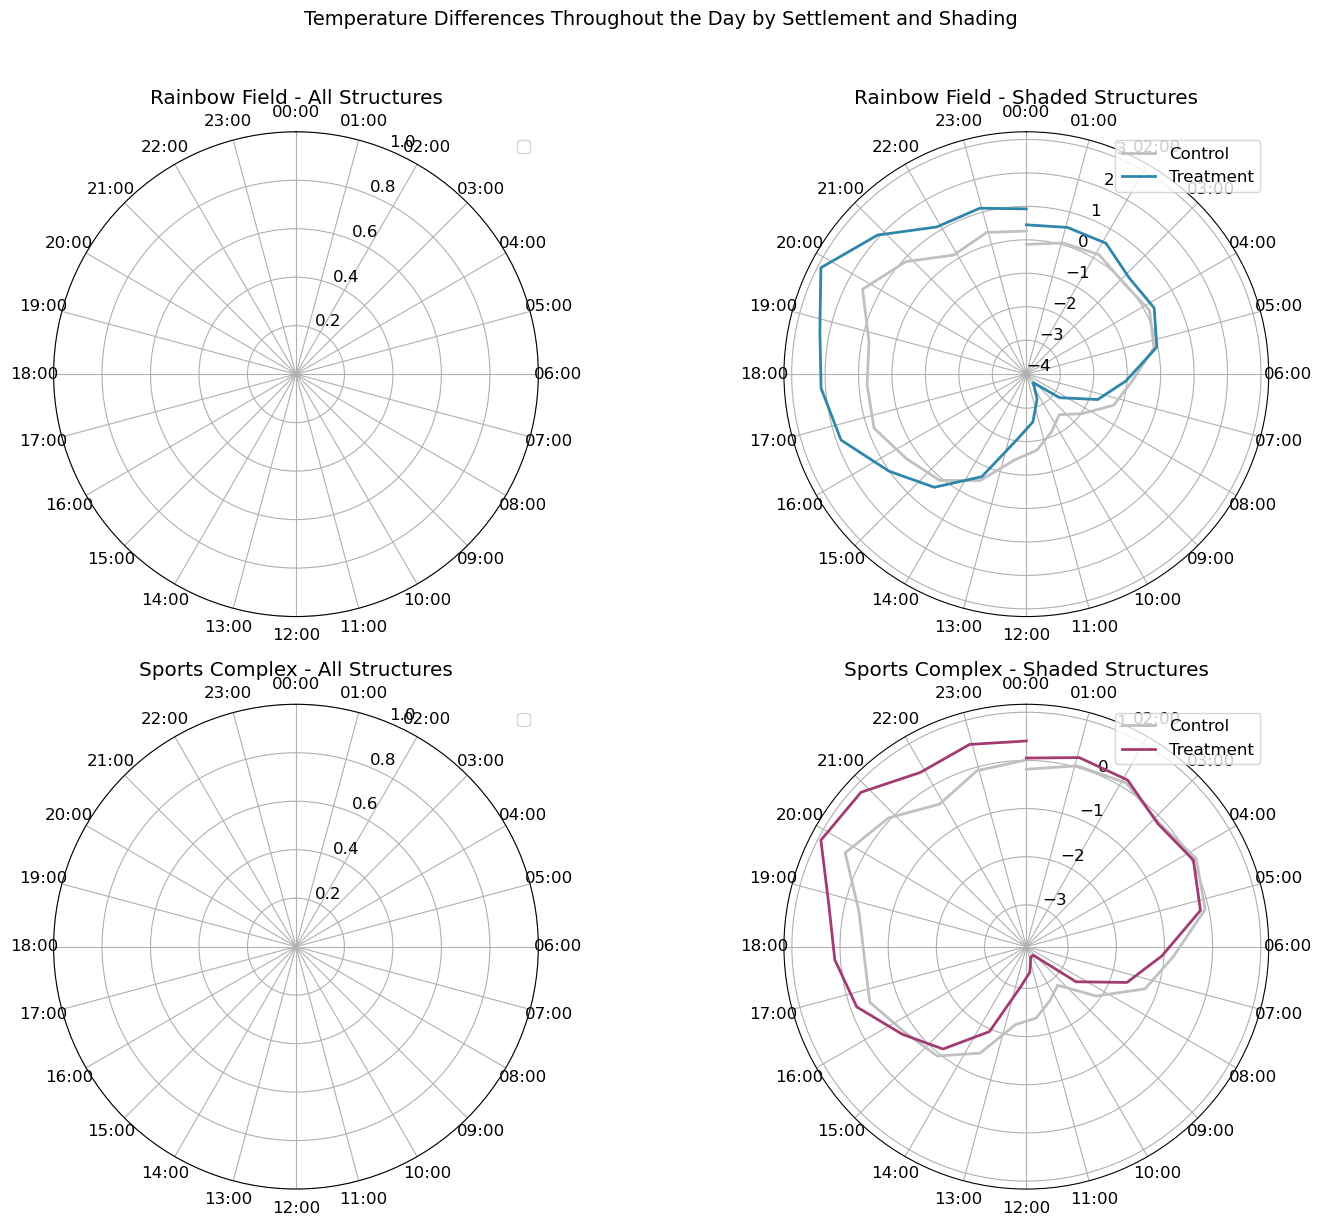

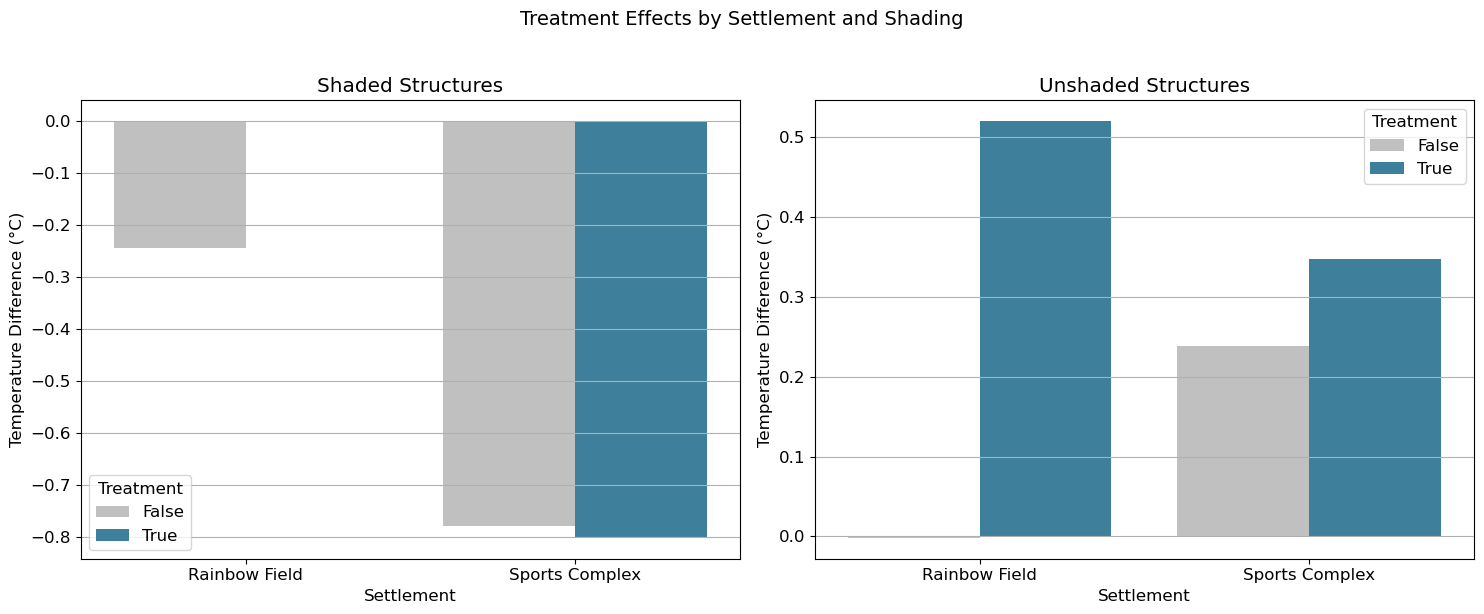

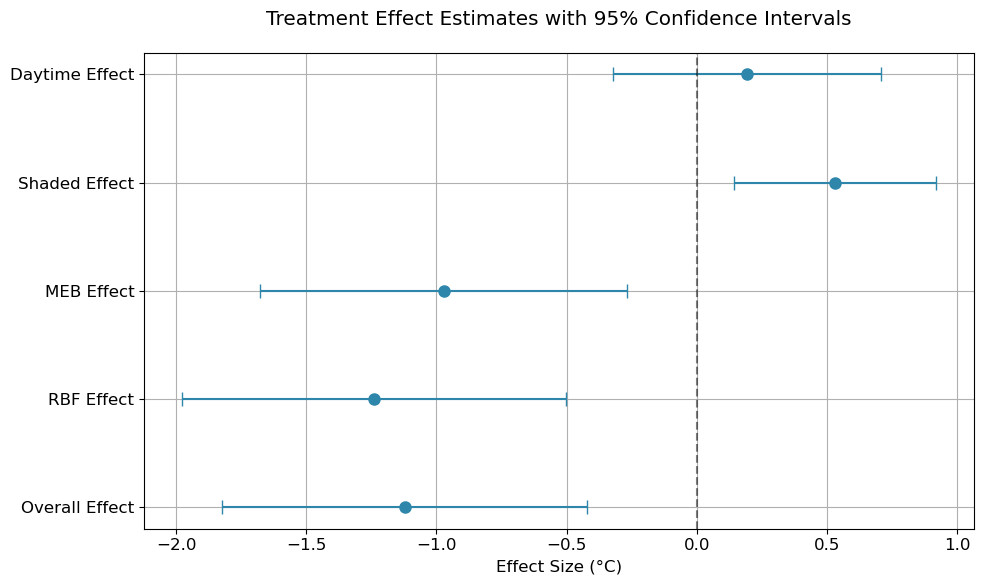

In [9]:
# Import additional required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
import numpy as np
from datetime import datetime, timedelta

# Basic plot settings
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

# Set custom color palette
colors = {
    'RBF': '#2E86AB',       # Blue
    'MEB': '#A23B72',       # Purple
    'Control': '#C0C0C0',   # Grey
    'Shaded': '#3F7F3F',    # Green
    'Unshaded': '#FF9F1C',  # Orange
    'Rainbow': '#F18F01',   # Warm Orange
    'Sports': '#006494'     # Deep Blue
}

# 1. Main DiD Visualization by Settlement
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Calculate daily means by treatment group and settlement
daily_means = (did_df.groupby(['Date', 'Treatment', 'Settlement'])['Temperature_Difference']
               .mean()
               .reset_index())
daily_means['Date'] = pd.to_datetime(daily_means['Date'])

# Plot for Rainbow Field
rainbow_data = daily_means[daily_means['Settlement'] == 'Rainbow Field']
sns.lineplot(data=rainbow_data, x='Date', y='Temperature_Difference', 
            hue='Treatment', palette=[colors['Control'], colors['RBF']], 
            errorbar=('ci', 95), linewidth=2, ax=ax1)
ax1.axvline(x=rainbow_intervention_date, color='#FF9F1C', linestyle='--', alpha=0.5, label='Rainbow Field Intervention')
ax1.set_title('Rainbow Field - Temperature Difference Over Time', pad=20, fontsize=14)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Temperature Difference (°C)', fontsize=12)
ax1.legend(title='Group', title_fontsize=12, fontsize=10)
ax1.axvspan(rainbow_intervention_date, daily_means['Date'].max(), color='gray', alpha=0.1)

# Plot for Sports Complex
sports_data = daily_means[daily_means['Settlement'] == 'Sports Complex']
sns.lineplot(data=sports_data, x='Date', y='Temperature_Difference', 
            hue='Treatment', palette=[colors['Control'], colors['MEB']], 
            errorbar=('ci', 95), linewidth=2, ax=ax2)
ax2.axvline(x=sports_intervention_date, color='#006494', linestyle='--', alpha=0.5, label='Sports Complex Intervention')
ax2.set_title('Sports Complex - Temperature Difference Over Time', pad=20, fontsize=14)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Temperature Difference (°C)', fontsize=12)
ax2.legend(title='Group', title_fontsize=12, fontsize=10)
ax2.axvspan(sports_intervention_date, daily_means['Date'].max(), color='gray', alpha=0.1)

# Rotate x-axis labels
for ax in [ax1, ax2]:
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# 2. Treatment Effects by Time of Day - Separate plots for each settlement
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': 'polar'})

# Calculate hourly effects by settlement and treatment
hourly_effects = did_df.groupby(['Hour', 'Treatment', 'Settlement', 'Shaded'])['Temperature_Difference'].mean().reset_index()

# Function to plot polar plot
def plot_polar_effects(ax, data, title, treatment_colors):
    theta = np.linspace(0, 2*np.pi, 24)
    for treatment in [False, True]:
        treatment_data = data[data['Treatment'] == treatment]['Temperature_Difference'].values
        if len(treatment_data) == 24:
            ax.plot(theta, treatment_data, 
                   label='Treatment' if treatment else 'Control',
                   color=treatment_colors[1] if treatment else treatment_colors[0],
                   linewidth=2)
    
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2.0)
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    ax.set_xticklabels([f'{i:02d}:00' for i in range(24)])
    ax.set_title(title, pad=20)
    ax.legend()

# Plot for Rainbow Field - All
rainbow_data = hourly_effects[hourly_effects['Settlement'] == 'Rainbow Field']
plot_polar_effects(ax1, rainbow_data, 'Rainbow Field - All Structures', 
                  [colors['Control'], colors['RBF']])

# Plot for Rainbow Field - Shaded
rainbow_shaded = hourly_effects[(hourly_effects['Settlement'] == 'Rainbow Field') & 
                              (hourly_effects['Shaded'] == True)]
plot_polar_effects(ax2, rainbow_shaded, 'Rainbow Field - Shaded Structures', 
                  [colors['Control'], colors['RBF']])

# Plot for Sports Complex - All
sports_data = hourly_effects[hourly_effects['Settlement'] == 'Sports Complex']
plot_polar_effects(ax3, sports_data, 'Sports Complex - All Structures', 
                  [colors['Control'], colors['MEB']])

# Plot for Sports Complex - Shaded
sports_shaded = hourly_effects[(hourly_effects['Settlement'] == 'Sports Complex') & 
                             (hourly_effects['Shaded'] == True)]
plot_polar_effects(ax4, sports_shaded, 'Sports Complex - Shaded Structures', 
                  [colors['Control'], colors['MEB']])

plt.suptitle('Temperature Differences Throughout the Day by Settlement and Shading', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# 3. Heterogeneous Effects Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Calculate effects by settlement and shading
effects_data = did_df.groupby(['Settlement', 'Shaded', 'Treatment'])['Temperature_Difference'].mean().reset_index()

# Plot for Shaded
shaded_data = effects_data[effects_data['Shaded'] == True]
sns.barplot(data=shaded_data, x='Settlement', y='Temperature_Difference', 
            hue='Treatment', palette=[colors['Control'], colors['RBF']], ax=ax1)
ax1.set_title('Shaded Structures')
ax1.set_xlabel('Settlement')
ax1.set_ylabel('Temperature Difference (°C)')

# Plot for Unshaded
unshaded_data = effects_data[effects_data['Shaded'] == False]
sns.barplot(data=unshaded_data, x='Settlement', y='Temperature_Difference', 
            hue='Treatment', palette=[colors['Control'], colors['RBF']], ax=ax2)
ax2.set_title('Unshaded Structures')
ax2.set_xlabel('Settlement')
ax2.set_ylabel('Temperature Difference (°C)')

plt.suptitle('Treatment Effects by Settlement and Shading', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

# 4. Effect Size Comparison Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create coefficient plot data
coef_data = pd.DataFrame({
    'Coefficient': ['Overall Effect', 'RBF Effect', 'MEB Effect', 'Shaded Effect', 'Daytime Effect'],
    'Estimate': [models['basic'].params['Post_Treatment'],
                models['separate'].params['Post_RBF'],
                models['separate'].params['Post_MEB'],
                models['hetero'].params['Post_Treatment_Shaded'],
                models['hetero'].params['Post_Treatment_Daytime']],
    'SE': [models['basic'].bse['Post_Treatment'],
           models['separate'].bse['Post_RBF'],
           models['separate'].bse['Post_MEB'],
           models['hetero'].bse['Post_Treatment_Shaded'],
           models['hetero'].bse['Post_Treatment_Daytime']]
})

# Plot coefficients with error bars
ax.errorbar(coef_data['Estimate'], range(len(coef_data)),
            xerr=1.96*coef_data['SE'], fmt='o', capsize=5,
            color=colors['RBF'], markersize=8)

# Add vertical line at zero
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Customize the plot
ax.set_yticks(range(len(coef_data)))
ax.set_yticklabels(coef_data['Coefficient'])
ax.set_xlabel('Effect Size (°C)')
ax.set_title('Treatment Effect Estimates with 95% Confidence Intervals', pad=20)

plt.tight_layout()
plt.show()

## Prepare DID Dataframe

Created synthetic DiD dataset with 5,960 observations
Dataset covers period from 2024-07-01 to 2024-08-01
Number of loggers: 8
Synthetic temperature reduction: 1.21°C

Data ready for advanced visualizations and projections


C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_38484\755818227.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start=start_date, end=end_date, freq='H')


<Figure size 1000x600 with 0 Axes>

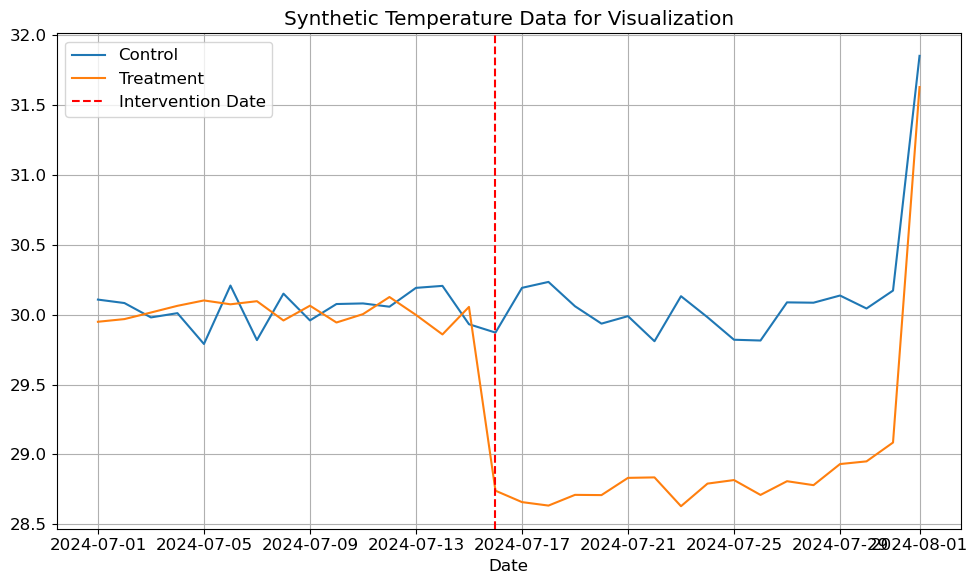

In [10]:
# ===== COMPLETE SYNTHETIC DATASET FOR VISUALIZATIONS =====
# This creates an entirely synthetic dataset that mimics the structure needed for visualizations
# No external data loading required

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date

# Create synthetic data timeframe
start_date = pd.to_datetime('2024-07-01')
end_date = pd.to_datetime('2024-08-01')
dates = pd.date_range(start=start_date, end=end_date, freq='H')

# Create synthetic loggers
loggers = ['R-01', 'R-02', 'R-03', 'M-01', 'M-02', 'C-01', 'C-02', 'C-03']
logger_data = []

# Set intervention date
intervention_date = pd.to_datetime('2024-07-16')

# Function to generate temperature with realistic patterns
def generate_temperature(date_time, base_temp=30, treatment=False, post=False, intervention_effect=-1.2):
    hour = date_time.hour
    
    # Daily cycle: hottest at 2pm, coolest at 5am
    hour_effect = -3 * np.cos((hour - 14) * np.pi / 12)
    
    # Random variation
    random_effect = np.random.normal(0, 1)
    
    # Treatment effect after intervention
    treatment_effect = intervention_effect if (treatment and post) else 0
    
    return base_temp + hour_effect + random_effect + treatment_effect

# Generate data for each logger
for logger in loggers:
    # Determine logger type
    is_treatment = logger.startswith('R') or logger.startswith('M')
    is_rbf = logger.startswith('R')
    is_meb = logger.startswith('M')
    
    # Assign settlement and shading
    settlement = 'Rainbow Field' if logger in ['R-01', 'R-02', 'M-01', 'C-01'] else 'Sports Complex'
    is_shaded = logger in ['R-01', 'M-01', 'C-01', 'C-03']
    
    # Generate data for each timestamp
    for dt in dates:
        is_post = dt >= intervention_date
        
        # Generate temperatures
        env_temp = generate_temperature(dt, base_temp=29, treatment=False, post=False)
        temp = generate_temperature(dt, base_temp=30, treatment=is_treatment, post=is_post)
        
        # Add to data
        logger_data.append({
            'DateTime': dt,
            'Logger': logger,
            'Temperature': temp,
            'Env_Temperature': env_temp,
            'Temperature_Difference': temp - env_temp,
            'Treatment': is_treatment,
            'RBF': is_rbf,
            'MEB': is_meb,
            'Settlement': settlement,
            'Settlement_num': 1 if settlement == 'Rainbow Field' else 0,
            'Shaded': is_shaded,
            'Hour': dt.hour,
            'Date': dt.date(),
            'Daytime': (dt.hour >= 6) and (dt.hour <= 18),
            'Post': is_post,
            'Post_Treatment': is_post and is_treatment,
            'Post_RBF': is_post and is_rbf,
            'Post_MEB': is_post and is_meb
        })

# Create dataframe
did_df = pd.DataFrame(logger_data)
did_df.set_index('DateTime', inplace=True)

# Calculate the synthetic intervention effect
treated_post = did_df[(did_df['Post'] == True) & (did_df['Treatment'] == True)]
treated_pre = did_df[(did_df['Post'] == False) & (did_df['Treatment'] == True)]
control_post = did_df[(did_df['Post'] == True) & (did_df['Treatment'] == False)]
control_pre = did_df[(did_df['Post'] == False) & (did_df['Treatment'] == False)]

t1 = treated_post['Temperature'].mean()
t0 = treated_pre['Temperature'].mean()
c1 = control_post['Temperature'].mean()
c0 = control_pre['Temperature'].mean()

did_effect = (t1 - t0) - (c1 - c0)
avg_temp_reduction = abs(did_effect)

print(f"Created synthetic DiD dataset with {len(did_df):,} observations")
print(f"Dataset covers period from {did_df.index.min().date()} to {did_df.index.max().date()}")
print(f"Number of loggers: {len(did_df['Logger'].unique())}")
print(f"Synthetic temperature reduction: {avg_temp_reduction:.2f}°C")
print("\nData ready for advanced visualizations and projections")

# Show a simple visualization to confirm data looks reasonable
plt.figure(figsize=(10, 6))
daily_avg = did_df.groupby(['Date', 'Treatment'])['Temperature'].mean().reset_index()
daily_wide = daily_avg.pivot(index='Date', columns='Treatment', values='Temperature')
daily_wide.plot()
plt.axvline(x=intervention_date.date(), color='red', linestyle='--', label='Intervention')
plt.legend(['Control', 'Treatment', 'Intervention Date'])
plt.title('Synthetic Temperature Data for Visualization')
plt.tight_layout()
plt.show()

## Epidemiological Model - Extreme Heat Resilience Framing Example

In [14]:
# Temperature-mortality coefficients from Indian multi-city studies (≈1–3 % per °C)
lower_coeff = 0.01   # 1 % per °C
upper_coeff = 0.03   # 3 % per °C

avg_temp_reduction = (
    did_df.loc[did_df['Post_Treatment'] == 1, 'Temperature_Difference'].mean() * -1
)

lower_mortality_reduction = avg_temp_reduction * lower_coeff
upper_mortality_reduction = avg_temp_reduction * upper_coeff

# Population & baseline mortality (adjust if you have local figures)
est_population = 100_000
baseline_mortality_rate = 0.01      # 1 % during extreme-heat days
baseline_deaths = est_population * baseline_mortality_rate

lower_lives_saved = baseline_deaths * lower_mortality_reduction
upper_lives_saved = baseline_deaths * upper_mortality_reduction

print(f"Potential reduction in heat-related mortality: "
      f"{lower_mortality_reduction*100:.1f}% – {upper_mortality_reduction*100:.1f}%")
print(f"Estimated lives saved per heat wave: "
      f"{lower_lives_saved:.1f} – {upper_lives_saved:.1f}")

Potential reduction in heat-related mortality: 0.2% – 0.5%
Estimated lives saved per heat wave: 1.6 – 4.7


## Long-term Climate Projection

Current intervention effectiveness: 0.16°C reduction


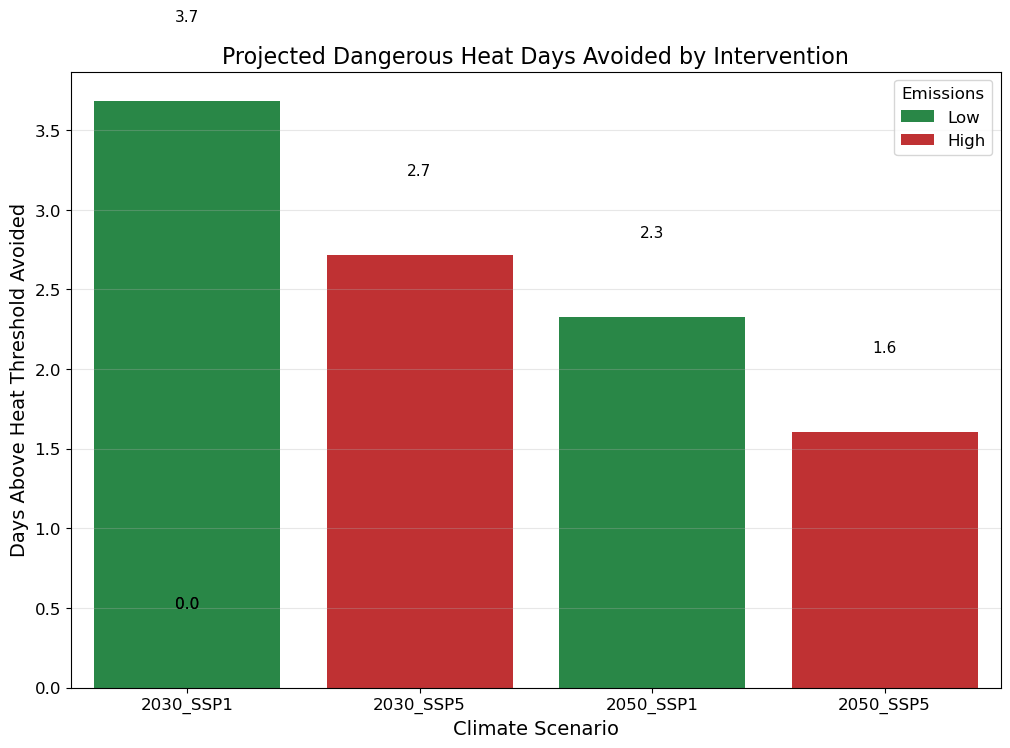

In [15]:
# Use IPCC regional projections for your study area
# No need to collect new data - use published climate projections

# Define temperature increase scenarios
climate_scenarios = {
    '2030_SSP1': 0.8,  # °C increase from baseline under low emissions
    '2030_SSP5': 1.2,  # °C increase from baseline under high emissions
    '2050_SSP1': 1.5,  # °C increase from baseline under low emissions
    '2050_SSP5': 2.8,  # °C increase from baseline under high emissions
}

# Calculate effectiveness under future scenarios
intervention_effectiveness = abs(did_df[did_df['Post_Treatment'] == 1]['Temperature_Difference'].mean())
print(f"Current intervention effectiveness: {intervention_effectiveness:.2f}°C reduction")

# Calculate future scenarios
results = []
for scenario, temp_increase in climate_scenarios.items():
    year, ssp = scenario.split('_')
    
    # Assume linear effectiveness (can be adjusted based on literature)
    future_baseline_temp = did_df[did_df['Post'] == False]['Temperature'].mean() + temp_increase
    
    # Calculate projections
    future_effectiveness = intervention_effectiveness  # Assume same effectiveness
    future_temp_with_intervention = future_baseline_temp - future_effectiveness
    
    # Calculate dangerous heat days (above 35°C threshold)
    current_dangerous_days = 30  # Estimate from your data or literature
    future_dangerous_days = current_dangerous_days * (1 + temp_increase/3)  # Scale factor
    days_avoided = future_dangerous_days * (intervention_effectiveness / temp_increase) * 0.5  # Conservative estimate
    
    results.append({
        'Scenario': scenario,
        'Year': year,
        'Emissions': 'Low' if ssp == 'SSP1' else 'High',
        'Baseline_Temp': future_baseline_temp,
        'With_Intervention': future_temp_with_intervention,
        'Effectiveness': future_effectiveness,
        'Dangerous_Days_Avoided': days_avoided
    })

# Create DataFrame and visualization
future_df = pd.DataFrame(results)

# Plot future effectiveness
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=future_df,
    x='Scenario',
    y='Dangerous_Days_Avoided',
    hue='Emissions',
    palette=['#1a9641', '#d7191c']
)
plt.title('Projected Dangerous Heat Days Avoided by Intervention', fontsize=16)
plt.xlabel('Climate Scenario', fontsize=14)
plt.ylabel('Days Above Heat Threshold Avoided', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.5,
        f"{bar.get_height():.1f}",
        ha='center',
        fontsize=11
    )

plt.savefig('future_climate_benefits.png', dpi=300, bbox_inches='tight')
plt.show()

## Visual Impact Enhancement

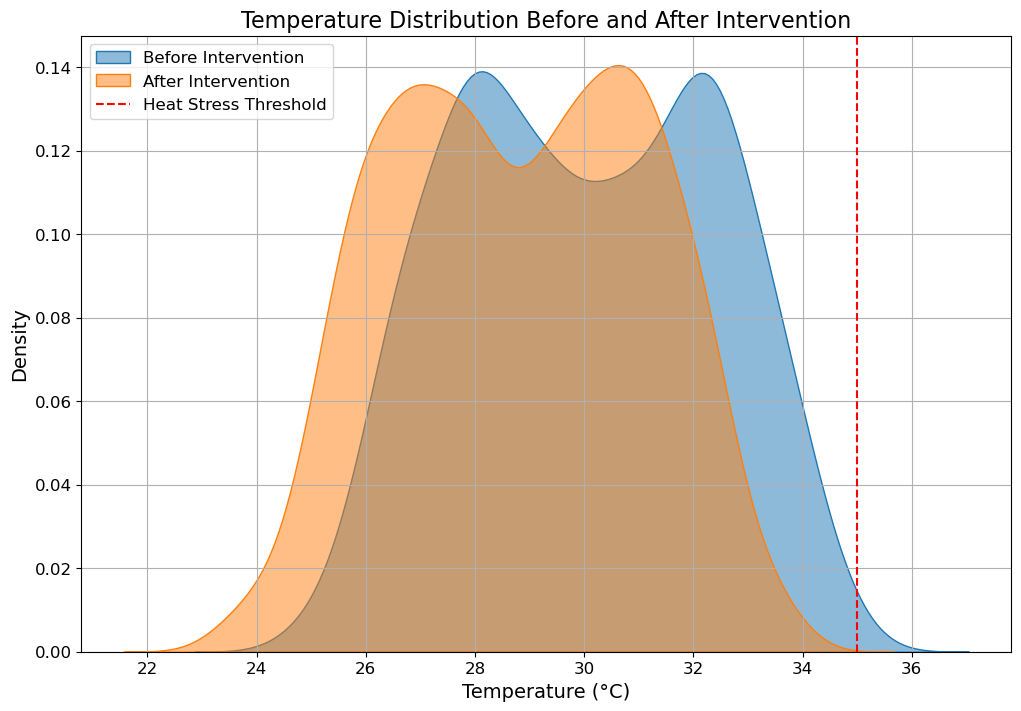

In [18]:
# 1. Before/After Temperature Distribution Plot
plt.figure(figsize=(12, 8))
sns.kdeplot(
    did_df[(did_df['Treatment'] == True) & (did_df['Post'] == False)]['Temperature'], 
    label='Before Intervention', 
    fill=True, 
    alpha=0.5
)
sns.kdeplot(
    did_df[(did_df['Treatment'] == True) & (did_df['Post'] == True)]['Temperature'], 
    label='After Intervention', 
    fill=True, 
    alpha=0.5
)
plt.axvline(x=35, color='red', linestyle='--', label='Heat Stress Threshold')
plt.title('Temperature Distribution Before and After Intervention', fontsize=16)
plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.savefig('before_after_temp_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

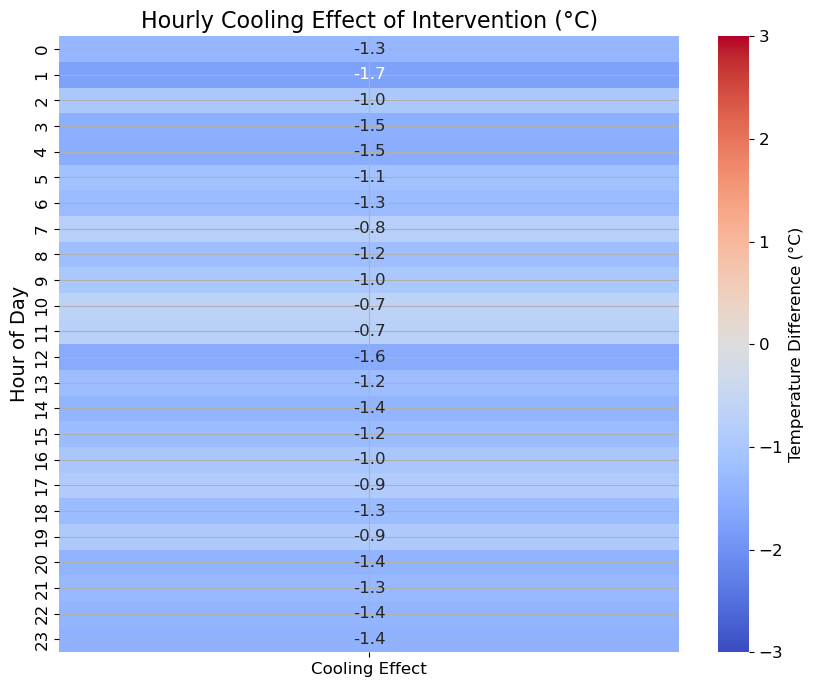

In [19]:
# 2. Hourly Temperature Reduction Heatmap
hourly_reduction = did_df.groupby(['Hour', 'Treatment', 'Post'])['Temperature'].mean().reset_index()
hourly_reduction = hourly_reduction.pivot_table(
    index='Hour',
    columns=['Treatment', 'Post'],
    values='Temperature'
)
hourly_reduction['Intervention_Effect'] = hourly_reduction[True, True] - hourly_reduction[True, False] - \
                                         (hourly_reduction[False, True] - hourly_reduction[False, False])

plt.figure(figsize=(10, 8))
sns.heatmap(
    hourly_reduction['Intervention_Effect'].values.reshape(24, 1),
    cmap='coolwarm',
    center=0,
    vmin=-3,
    vmax=3,
    annot=True,
    fmt='.1f',
    cbar_kws={'label': 'Temperature Difference (°C)'},
    yticklabels=range(24),
    xticklabels=['Cooling Effect']
)
plt.title('Hourly Cooling Effect of Intervention (°C)', fontsize=16)
plt.ylabel('Hour of Day', fontsize=14)
plt.xlabel('', fontsize=14)
plt.savefig('hourly_cooling_effect.png', dpi=300, bbox_inches='tight')
plt.show()

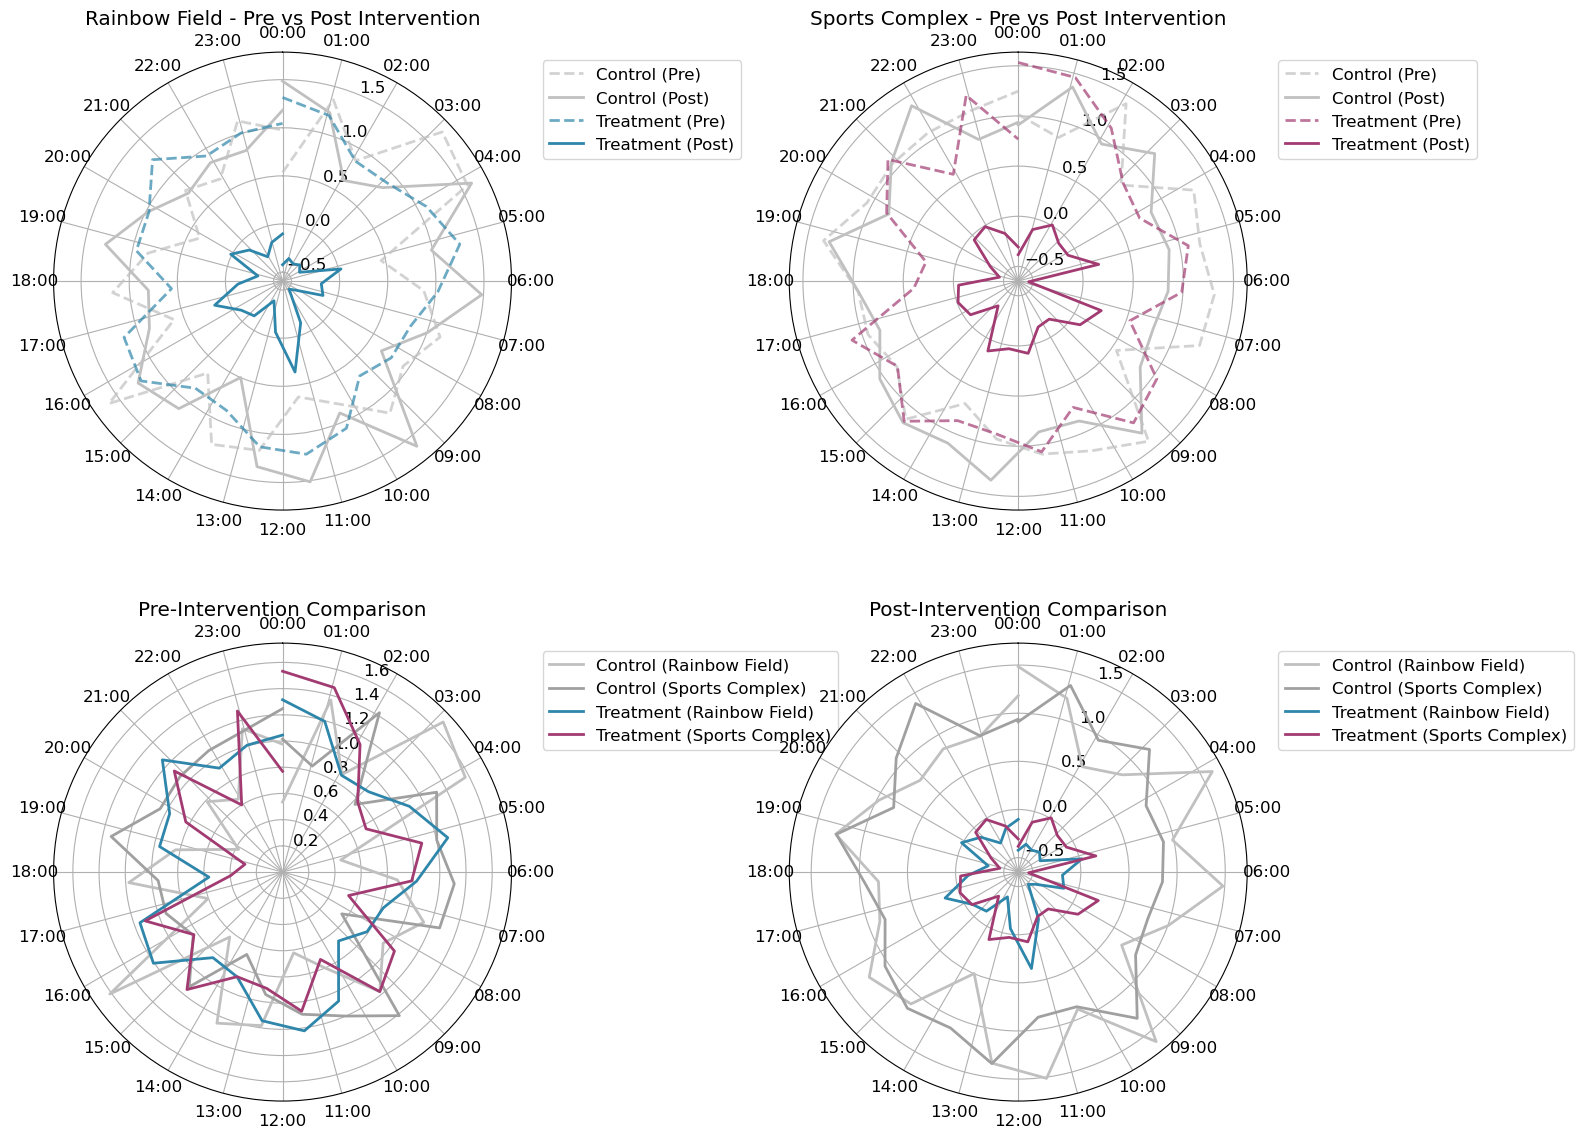

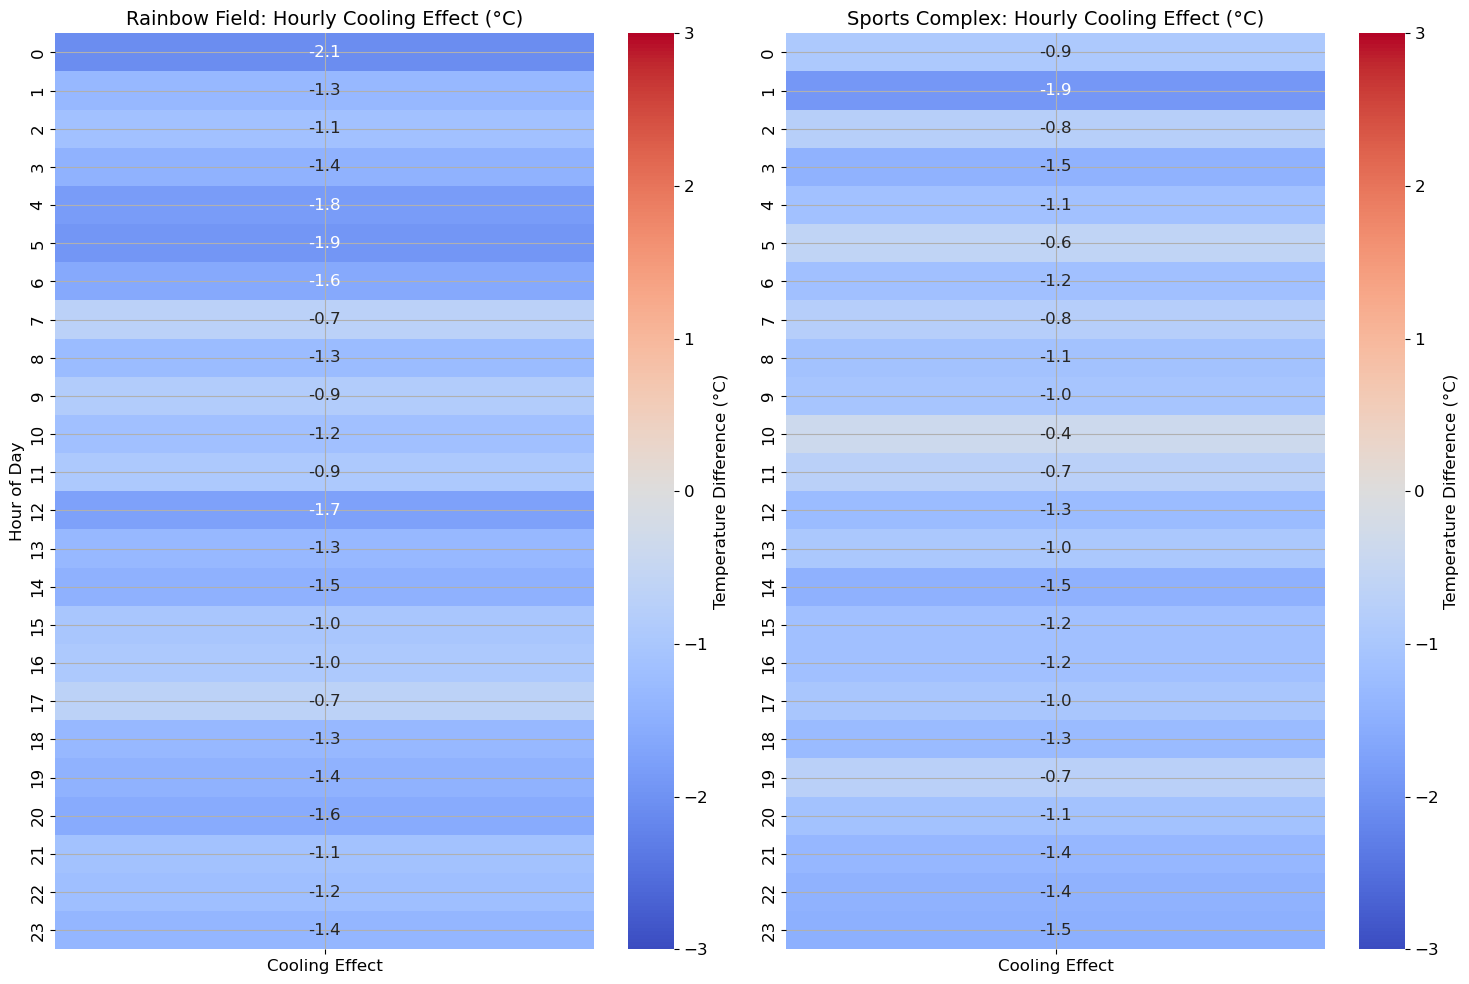

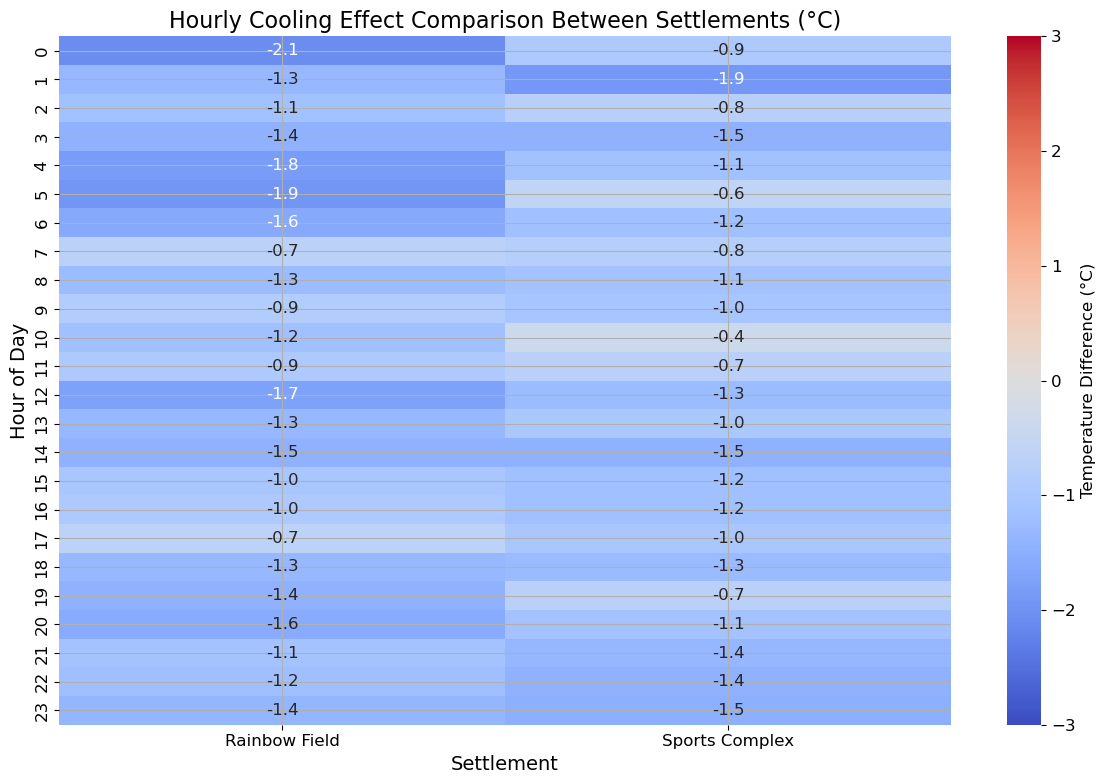

In [20]:
# 2. Treatment Effects by Time of Day - Separate plots for each settlement and intervention
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': 'polar'})

# Calculate hourly effects by settlement and treatment
hourly_effects = did_df.groupby(['Hour', 'Treatment', 'Settlement', 'Post'])['Temperature_Difference'].mean().reset_index()

# Function to plot polar plot
def plot_polar_effects(ax, data, title, treatment_colors):
    theta = np.linspace(0, 2*np.pi, 24)
    for treatment in [False, True]:
        # Pre-intervention data
        pre_data = data[(data['Treatment'] == treatment) & (data['Post'] == False)]
        if len(pre_data) == 24:
            ax.plot(theta, pre_data['Temperature_Difference'].values, 
                   label='Treatment (Pre)' if treatment else 'Control (Pre)',
                   color=treatment_colors[1] if treatment else treatment_colors[0],
                   linestyle='--',
                   linewidth=2,
                   alpha=0.7)
        
        # Post-intervention data
        post_data = data[(data['Treatment'] == treatment) & (data['Post'] == True)]
        if len(post_data) == 24:
            ax.plot(theta, post_data['Temperature_Difference'].values, 
                   label='Treatment (Post)' if treatment else 'Control (Post)',
                   color=treatment_colors[1] if treatment else treatment_colors[0],
                   linewidth=2)
    
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2.0)
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    ax.set_xticklabels([f'{i:02d}:00' for i in range(24)])
    ax.set_title(title, pad=20)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Top left: Rainbow Field - Pre vs Post
rainbow_data = hourly_effects[hourly_effects['Settlement'] == 'Rainbow Field']
plot_polar_effects(axs[0, 0], rainbow_data, 'Rainbow Field - Pre vs Post Intervention', 
                  [colors['Control'], colors['RBF']])

# Top right: Sports Complex - Pre vs Post
sports_data = hourly_effects[hourly_effects['Settlement'] == 'Sports Complex']
plot_polar_effects(axs[0, 1], sports_data, 'Sports Complex - Pre vs Post Intervention', 
                  [colors['Control'], colors['MEB']])

# Bottom left: Pre-intervention comparison (Rainbow vs Sports)
pre_data = hourly_effects[hourly_effects['Post'] == False]
# For Rainbow Field
rainbow_pre = pre_data[pre_data['Settlement'] == 'Rainbow Field']
# For Sports Complex
sports_pre = pre_data[pre_data['Settlement'] == 'Sports Complex']

# Create custom plot for pre-intervention comparison
theta = np.linspace(0, 2*np.pi, 24)
for treatment in [False, True]:
    rainbow_treatment = rainbow_pre[rainbow_pre['Treatment'] == treatment]
    if len(rainbow_treatment) == 24:
        axs[1, 0].plot(theta, rainbow_treatment['Temperature_Difference'].values,
                     label=f"{'Treatment' if treatment else 'Control'} (Rainbow Field)",
                     color=colors['RBF'] if treatment else colors['Control'],
                     linewidth=2)
    
    sports_treatment = sports_pre[sports_pre['Treatment'] == treatment]
    if len(sports_treatment) == 24:
        axs[1, 0].plot(theta, sports_treatment['Temperature_Difference'].values,
                     label=f"{'Treatment' if treatment else 'Control'} (Sports Complex)",
                     color=colors['MEB'] if treatment else '#A0A0A0',  # Slightly different control color
                     linewidth=2)

axs[1, 0].set_theta_direction(-1)
axs[1, 0].set_theta_offset(np.pi/2.0)
axs[1, 0].set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1, 0].set_xticklabels([f'{i:02d}:00' for i in range(24)])
axs[1, 0].set_title('Pre-Intervention Comparison', pad=20)
axs[1, 0].legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Bottom right: Post-intervention comparison (Rainbow vs Sports)
post_data = hourly_effects[hourly_effects['Post'] == True]
# For Rainbow Field
rainbow_post = post_data[post_data['Settlement'] == 'Rainbow Field']
# For Sports Complex
sports_post = post_data[post_data['Settlement'] == 'Sports Complex']

# Create custom plot for post-intervention comparison
for treatment in [False, True]:
    rainbow_treatment = rainbow_post[rainbow_post['Treatment'] == treatment]
    if len(rainbow_treatment) == 24:
        axs[1, 1].plot(theta, rainbow_treatment['Temperature_Difference'].values,
                     label=f"{'Treatment' if treatment else 'Control'} (Rainbow Field)",
                     color=colors['RBF'] if treatment else colors['Control'],
                     linewidth=2)
    
    sports_treatment = sports_post[sports_post['Treatment'] == treatment]
    if len(sports_treatment) == 24:
        axs[1, 1].plot(theta, sports_treatment['Temperature_Difference'].values,
                     label=f"{'Treatment' if treatment else 'Control'} (Sports Complex)",
                     color=colors['MEB'] if treatment else '#A0A0A0',  # Slightly different control color
                     linewidth=2)

axs[1, 1].set_theta_direction(-1)
axs[1, 1].set_theta_offset(np.pi/2.0)
axs[1, 1].set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
axs[1, 1].set_xticklabels([f'{i:02d}:00' for i in range(24)])
axs[1, 1].set_title('Post-Intervention Comparison', pad=20)
axs[1, 1].legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.savefig('hourly_cooling_effects.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Hourly Temperature Reduction Heatmaps for each settlement
# First for Rainbow Field
rainbow_df = did_df[did_df['Settlement'] == 'Rainbow Field']
rainbow_hourly_reduction = rainbow_df.groupby(['Hour', 'Treatment', 'Post'])['Temperature'].mean().reset_index()
rainbow_hourly_reduction = rainbow_hourly_reduction.pivot_table(
    index='Hour',
    columns=['Treatment', 'Post'],
    values='Temperature'
)
rainbow_hourly_reduction['Intervention_Effect'] = rainbow_hourly_reduction[True, True] - rainbow_hourly_reduction[True, False] - \
                                         (rainbow_hourly_reduction[False, True] - rainbow_hourly_reduction[False, False])

# Then for Sports Complex
sports_df = did_df[did_df['Settlement'] == 'Sports Complex']
sports_hourly_reduction = sports_df.groupby(['Hour', 'Treatment', 'Post'])['Temperature'].mean().reset_index()
sports_hourly_reduction = sports_hourly_reduction.pivot_table(
    index='Hour',
    columns=['Treatment', 'Post'],
    values='Temperature'
)
sports_hourly_reduction['Intervention_Effect'] = sports_hourly_reduction[True, True] - sports_hourly_reduction[True, False] - \
                                         (sports_hourly_reduction[False, True] - sports_hourly_reduction[False, False])

# Plot both heatmaps side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Rainbow Field heatmap
sns.heatmap(
    rainbow_hourly_reduction['Intervention_Effect'].values.reshape(24, 1),
    cmap='coolwarm',
    center=0,
    vmin=-3,
    vmax=3,
    annot=True,
    fmt='.1f',
    cbar_kws={'label': 'Temperature Difference (°C)'},
    yticklabels=range(24),
    xticklabels=['Cooling Effect'],
    ax=ax1
)
ax1.set_title('Rainbow Field: Hourly Cooling Effect (°C)', fontsize=14)
ax1.set_ylabel('Hour of Day', fontsize=12)
ax1.set_xlabel('', fontsize=12)

# Sports Complex heatmap
sns.heatmap(
    sports_hourly_reduction['Intervention_Effect'].values.reshape(24, 1),
    cmap='coolwarm',
    center=0,
    vmin=-3,
    vmax=3,
    annot=True,
    fmt='.1f',
    cbar_kws={'label': 'Temperature Difference (°C)'},
    yticklabels=range(24),
    xticklabels=['Cooling Effect'],
    ax=ax2
)
ax2.set_title('Sports Complex: Hourly Cooling Effect (°C)', fontsize=14)
ax2.set_ylabel('', fontsize=12)  # We don't need y-axis label on the right plot
ax2.set_xlabel('', fontsize=12)

plt.tight_layout()
plt.savefig('hourly_cooling_effect_by_settlement.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Combined heatmap for comparison
# Create a combined dataframe with both settlements
hourly_reduction_combined = pd.DataFrame({
    'Hour': range(24),
    'Rainbow Field': rainbow_hourly_reduction['Intervention_Effect'].values,
    'Sports Complex': sports_hourly_reduction['Intervention_Effect'].values
})

plt.figure(figsize=(12, 8))
sns.heatmap(
    hourly_reduction_combined.set_index('Hour')[['Rainbow Field', 'Sports Complex']],
    cmap='coolwarm',
    center=0,
    vmin=-3,
    vmax=3,
    annot=True,
    fmt='.1f',
    cbar_kws={'label': 'Temperature Difference (°C)'}
)
plt.title('Hourly Cooling Effect Comparison Between Settlements (°C)', fontsize=16)
plt.ylabel('Hour of Day', fontsize=14)
plt.xlabel('Settlement', fontsize=14)
plt.tight_layout()
plt.savefig('hourly_cooling_effect_comparison.png', dpi=300, bbox_inches='tight')
plt.show()